In [1]:
import xarray
import spires
import numpy as np
import matplotlib.pyplot as plt

In [2]:
interpolator = spires.LutInterpolator(lut_file='../tests/data/lut_sentinel2b_b2to12_3um_dust.mat')

In [3]:
bands = interpolator.bands
solar_angles = interpolator.solar_angles
dust_concentrations = interpolator.dust_concentrations
grain_sizes = interpolator.grain_sizes
reflectances = interpolator.reflectances

In [4]:
r = xarray.load_dataset('../tests/data/sentinel_r.nc')
r0 = xarray.load_dataset('../tests/data/sentinel_r0.nc')

In [5]:
x0 = np.array([0.5, 0.05, 10, 250])

In [6]:
reflectance = r['reflectance']

b8_b4 = (reflectance.sel(band='B8') + reflectance.sel(band='B4'))
b8_b4 = b8_b4.where(b8_b4!=0)
ndvi = (reflectance.sel(band='B8') - reflectance.sel(band='B4')) / b8_b4

b3_b11 = (reflectance.sel(band='B3') + reflectance.sel(band='B11'))
b3_b11 = b3_b11.where(b3_b11!=0)
ndsi = (reflectance.sel(band='B3') - reflectance.sel(band='B11')) / b3_b11

ndsi = ndsi.where(ndsi<1).where(ndsi>-1)
ndvi = ndvi.where(ndvi<1).where(ndvi>-1)

r['ndvi'] = ndvi
r['ndsi'] = ndsi

In [7]:
r.time

<xarray.DataArray 'time' (time: 2)> Size: 16B
array(['2024-02-25T18:43:39.024000000', '2024-03-01T18:43:11.024000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-02-25T18:43:39.024000 2024-03-01T...

# Invert One

In [96]:
date = '2024-02-25'
ts = r.sel(time=date).squeeze().drop_vars('time')

In [97]:
spectrum_target = ts.isel(x=0, y=0)['reflectance'].values
spectrum_background = r0.isel(x=0, y=0)['reflectance'].values
spectrum_shade = np.zeros_like(spectrum_target)
solar_angle = ts.attrs['sun_zenith_mean']

In [98]:
#%%timeit
res = spires.speedy_invert(spectrum_background=spectrum_background, 
                           spectrum_target=spectrum_target,
                           spectrum_shade=spectrum_shade,                          
                           solar_angle=solar_angle, 
                           interpolator=interpolator,                     
                           max_eval=500,
                           x0=x0,
                           algorithm=2)

In [99]:
res

(0.8581654503805568, 0.0, 864.2248010098045, 631.9067427140509)

# Invert all

In [186]:
spectra_targets = ts['reflectance'].stack(yx=('y', 'x')).transpose('yx', 'band')
spectra_backgrounds = r0['reflectance'].stack(yx=('y', 'x')).transpose('yx', 'band')
obs_solar_angles = ts['sun_zenith_grid'].stack(yx=('y', 'x'))
spectrum_shade = np.zeros_like(spectrum_target)

In [ ]:
%%time
results = []
for yx in spectra_targets.yx:
    spectrum_target = spectra_targets.sel(yx=yx)
    spectrum_background = spectra_backgrounds.sel(yx=yx)
    solar_angle = float(obs_solar_angles.sel(yx=yx))        

    res = spires.speedy_invert(spectrum_background=spectrum_background, 
                               spectrum_target=spectrum_target,
                               spectrum_shade=spectrum_shade,                          
                               solar_angle=solar_angle, 
                               interpolator=interpolator,
                               max_eval=25,
                               x0=x0,
                               algorithm=2)    
    results.append(res)
    
results = np.array(results)

In [190]:
%%time
results = spires.speedy_invert_array1d(spectra_targets=spectra_targets.values,
                                       spectra_backgrounds=spectra_backgrounds.values,
                                       obs_solar_angles=obs_solar_angles.values,
                                       interpolator=interpolator)

CPU times: user 45.4 s, sys: 151 ms, total: 45.5 s
Wall time: 45.5 s


In [103]:
shape = (ts.reflectance.y.shape[0], ts.reflectance.x.shape[0], 4)
result = results.reshape(shape)

ts['fsca'] = xarray.DataArray(result[:, :, 0], dims=('y', 'x'))
ts['fshade'] = xarray.DataArray(result[:, :, 1], dims=('y', 'x'))
ts['dust_concentration'] = xarray.DataArray(result[:, :, 2], dims=('y', 'x'))
ts['grain_size'] = xarray.DataArray(result[:, :, 3], dims=('y', 'x'))

In [104]:
results_ds = xarray.Dataset()
results_ds['fsca'] = xarray.DataArray(result[:, :, 0], dims=('y', 'x'))
results_ds['fshade'] = xarray.DataArray(result[:, :, 1], dims=('y', 'x'))
results_ds['dust_concentration'] = xarray.DataArray(result[:, :, 2], dims=('y', 'x'))
results_ds['grain_size'] = xarray.DataArray(result[:, :, 3], dims=('y', 'x'))
results_ds['x'] = r.x
results_ds['y'] = r.y
results_ds

<xarray.Dataset> Size: 40MB
Dimensions:             (y: 921, x: 1347)
Coordinates:
  * x                   (x) float64 11kB 3.146e+05 3.146e+05 ... 3.28e+05
  * y                   (y) float64 7kB 4.171e+06 4.171e+06 ... 4.162e+06
Data variables:
    fsca                (y, x) float64 10MB 0.9633 0.2839 ... 0.2235 0.1359
    fshade              (y, x) float64 10MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.02699
    dust_concentration  (y, x) float64 10MB 649.4 129.6 738.5 ... 0.0 0.0 7.931
    grain_size          (y, x) float64 10MB 1.171e+03 507.5 ... 30.0 30.78

In [211]:
from dask.distributed import LocalCluster
import dask.distributed
import logging

cluster = dask.distributed.LocalCluster(n_workers=10, 
                                        threads_per_worker=1, 
                                        memory_limit='5GB', 
                                        processes=True, 
                                        dashboard_address='localhost:8787',
                                        silence_logs=logging.ERROR)

/Users/griessban/miniconda3/envs/spipy/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56599 instead
  warnings.warn(


In [212]:
def invert_xarray(spectra_targets, spectra_backgrounds, obs_solar_angles):    
    results = spires.speedy_invert_array1d(spectra_targets=spectra_targets,
                                           spectra_backgrounds=spectra_backgrounds,
                                           obs_solar_angles=obs_solar_angles,
                                           interpolator=interpolator)
    return results

In [213]:
r_in = ts['reflectance'].stack(yx=('y', 'x')).transpose('yx', 'band').chunk(yx=10000)
r0_in = r0['reflectance'].stack(yx=('y', 'x')).transpose('yx', 'band').chunk(yx=10000)
sa_in = ts['sun_zenith_grid'].stack(yx=('y', 'x')).chunk(yx=10000)

In [214]:
r_in

<xarray.DataArray 'reflectance' (yx: 1240587, band: 9)> Size: 45MB
dask.array<xarray-<this-array>, shape=(1240587, 9), dtype=float32, chunksize=(10000, 9), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U3 108B 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B11' 'B12' 'B8'
    spatial_ref  int64 8B 0
  * yx           (yx) object 10MB MultiIndex
  * y            (yx) float64 10MB 4.171e+06 4.171e+06 ... 4.162e+06 4.162e+06
  * x            (yx) float64 10MB 3.146e+05 3.146e+05 ... 3.28e+05 3.28e+05
Attributes: (12/84)
    AOT_QUANTIFICATION_VALUE:              1000.0
    AOT_QUANTIFICATION_VALUE_UNIT:         none
    AOT_RETRIEVAL_ACCURACY:                0.0
    AOT_RETRIEVAL_METHOD:                  SEN2COR_DDV
    BOA_QUANTIFICATION_VALUE:              10000
    BOA_QUANTIFICATION_VALUE_UNIT:         none
    ...                                    ...
    viewing_zenith_mean_B5:                5.55509677905887
    viewing_zenith_mean_B6:                5.59921210713732
    viewing_zenith_mean_B7:                5.64492094942767
    viewing_zenith_mean_B8:                5.4248694111022
    viewing_zenith_mean_B8A:               5.69907913532304
    viewing_zenith_mean_B9:                5.80704603536241

In [215]:
%%time
res = xarray.apply_ufunc(invert_xarray,
                         r_in,
                         r0_in,
                         sa_in,
                         dask='parallelized',
                         input_core_dims=[['band'], ['band'], []],
                         output_core_dims=[['property']],
                         dask_gufunc_kwargs={'allow_rechunk': False, 'output_sizes': {'property': 4}},
                         output_dtypes=[float],
                         vectorize=False)

with dask.distributed.Client(cluster) as client:
    res = res.compute()

/Users/griessban/miniconda3/envs/spipy/lib/python3.12/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 174.57 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3.45 s, sys: 6.45 s, total: 9.9 s
Wall time: 14 s


In [204]:
cluster.close()

In [216]:
res

<xarray.DataArray (yx: 1240587, property: 4)> Size: 40MB
array([[9.63259431e-01, 0.00000000e+00, 6.49353634e+02, 1.17120886e+03],
       [2.83946861e-01, 0.00000000e+00, 1.29616305e+02, 5.07527026e+02],
       [7.41671411e-01, 0.00000000e+00, 7.38506177e+02, 1.09101886e+03],
       ...,
       [2.22510146e-01, 0.00000000e+00, 0.00000000e+00, 3.00000000e+01],
       [2.23504038e-01, 0.00000000e+00, 0.00000000e+00, 3.00000000e+01],
       [1.35933824e-01, 2.69882276e-02, 7.93106034e+00, 3.07768281e+01]])
Coordinates:
    spatial_ref  int64 8B 0
  * yx           (yx) object 10MB MultiIndex
  * y            (yx) float64 10MB 4.171e+06 4.171e+06 ... 4.162e+06 4.162e+06
  * x            (yx) float64 10MB 3.146e+05 3.146e+05 ... 3.28e+05 3.28e+05
Dimensions without coordinates: property

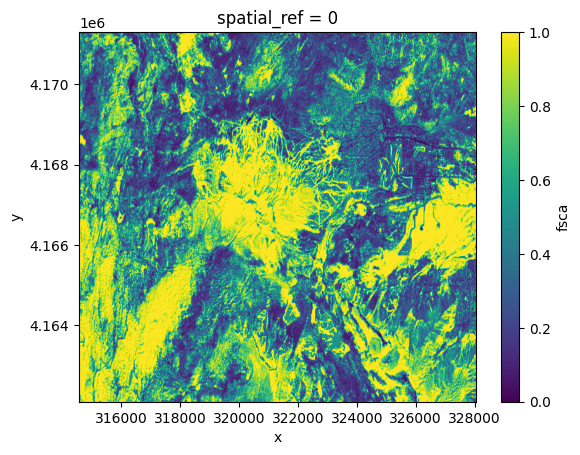

In [108]:
ts['fsca'].plot.imshow(interpolation=None)

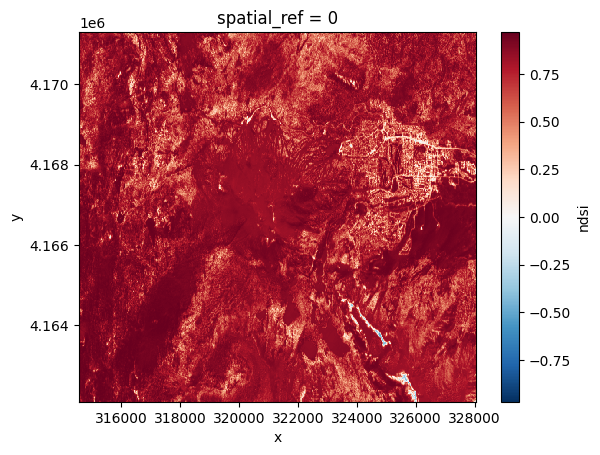

In [109]:
ts['ndsi'].plot.imshow()

In [110]:
ts.rio.write_crs(32611, inplace=True)
ts.rio.set_spatial_dims('x', 'y', inplace=True)
ts['reflectance'].squeeze().to_dataset('band').rio.to_raster(f'{date}_r.tiff')
ts['ndsi'].squeeze().to_dataset().rio.to_raster(f'{date}_ndsi.tiff')

r0.rio.write_crs(32611, inplace=True)
r0.rio.set_spatial_dims('x', 'y', inplace=True)
r0['reflectance'].squeeze().to_dataset('band').rio.to_raster(f'{date}_r0.tiff')

results_ds.rio.write_crs(32611, inplace=True)
results_ds.rio.set_spatial_dims('x', 'y', inplace=True)
results_ds.rio.to_raster(f'{date}_spires.tiff')